# Vision Large Language Models for Counting objects
In this notebook we use OpenAI's LLMs with Vision capabilities to see how well they can count blobs in blobs.tif.

Note: It is not recommended to use this approach for counting objects in microscopy images. The author of this notebook is not aware of any publication showing that this approach works well.

You need to install [openai](https://pypi.org/project/openai/) and configure an API key in your environment variables to make this notebook work.

```
pip install openai==1.30.1
```

In [1]:
import openai
import PIL
import stackview
from skimage.io import imread
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

We will need some helper functions for assembling a prompt and submitting it to the openai server.

In [2]:
def prompt_with_image(message:str, image, model="gpt-4o-2024-05-13"):
    """A prompt helper function that sends a text message and an image
    to openAI and returns the text response.
    """
    import os
    
    # convert message in the right format if necessary
    if isinstance(message, str):
        message = [{"role": "user", "content": message}]
    
    image_message = image_to_message(image)
        
    # setup connection to the LLM
    client = openai.OpenAI()
    
    # submit prompt
    response = client.chat.completions.create(
        model=model,
        messages=message + image_message
    )
    
    # extract answer
    return response.choices[0].message.content


def image_to_message(image):
    import base64

    from stackview._image_widget import _img_to_rgb

    rgb_image = _img_to_rgb(image)
    byte_stream = numpy_to_bytestream(rgb_image)
    base64_image = base64.b64encode(byte_stream).decode('utf-8')

    return [{"role": "user", "content": [{
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }

    }]}]


def numpy_to_bytestream(data):
    """Turn a NumPy array into a bytestream"""
    import numpy as np
    from PIL import Image
    import io

    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(data.astype(np.uint8)).convert("RGBA")

    # Create a BytesIO object
    bytes_io = io.BytesIO()

    # Save the PIL image to the BytesIO object as a PNG
    image.save(bytes_io, format='PNG')

    # return the beginning of the file as a bytestream
    bytes_io.seek(0)
    return bytes_io.read()

This is the example image we will be using.

StackViewNDArray([[ 40,  32,  24, ..., 216, 200, 200],
                  [ 56,  40,  24, ..., 232, 216, 216],
                  [ 64,  48,  24, ..., 240, 232, 232],
                  ...,
                  [ 72,  80,  80, ...,  48,  48,  48],
                  [ 80,  80,  80, ...,  48,  48,  48],
                  [ 96,  88,  80, ...,  48,  48,  48]], dtype=uint8)
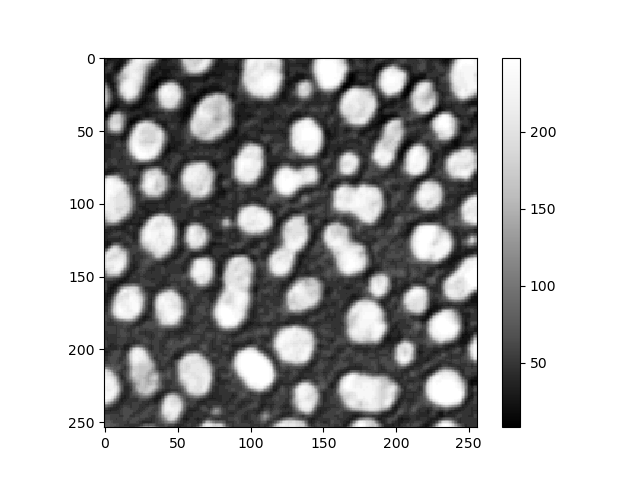
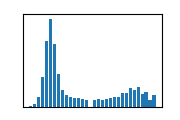

In [3]:
image = imread("../../data/blobs.tif")
stackview.insight(image)

This is the prompt we submit to the server.

In [4]:
my_prompt = """
Analyse the following image by counting the bright blobs. Respond with the number only.
"""

prompt_with_image(my_prompt, image)

'46'

## Benchmarking vision-LLMs
We can run this prompt in a loop for a couple of vision models.

In [5]:
num_samples = 25

models = {
    "gpt-4o-2024-05-13":[],
    "gpt-4-turbo-2024-04-09":[],    
}
for model in models.keys():
    samples = []

    while len(samples) < num_samples:
        result = prompt_with_image(my_prompt, image)

        try:
            samples.append(int(result))
        except:
            print("Error processing result:", result)
    
    models[model] = samples

sampled_models = pd.DataFrame(models)

Let's get an overview about samples:

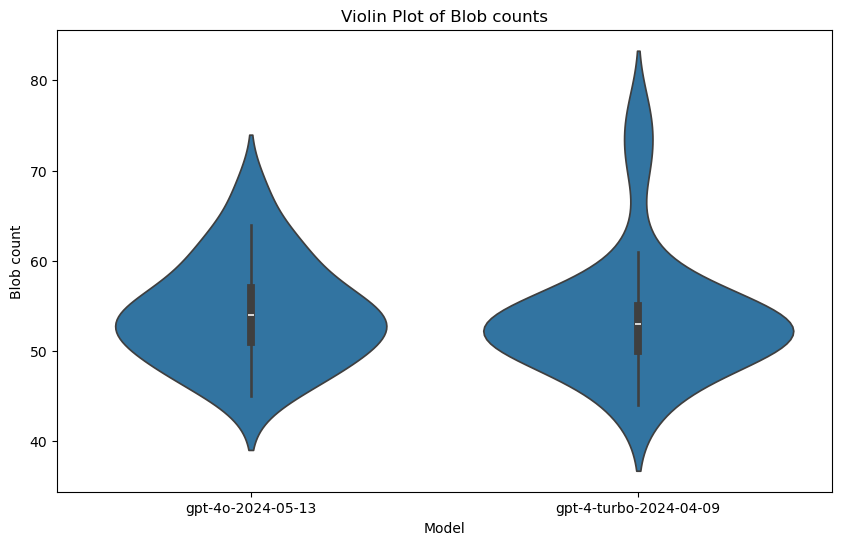

In [7]:
# Extract the two columns for comparison
columns_to_plot = sampled_models[["gpt-4o-2024-05-13", "gpt-4-turbo-2024-04-09"]]

# Melt the dataframe to prepare for plotting
df_melted = columns_to_plot.melt(var_name='Model', value_name='Blob count')

# Draw the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Model', y='Blob count', data=df_melted)
plt.title('Violin Plot of Blob counts')
plt.show()

These are the results in detail:

In [8]:
sampled_models

,gpt-4o-2024-05-13,gpt-4-turbo-2024-04-09
0,51,52
1,64,54
2,54,55
3,48,51
4,45,50
5,51,71
6,52,51
7,53,50
8,68,57
9,52,50


In [9]:
sampled_models.describe()

,gpt-4o-2024-05-13,gpt-4-turbo-2024-04-09
count,25.000000,25.000000
mean,54.200000,53.760000
std,5.686241,6.929887
min,45.000000,44.000000
25%,51.000000,50.000000
50%,54.000000,53.000000
75%,57.000000,55.000000
max,68.000000,76.000000
